# FIT simulations

### Little bit of theory:

**Transfer entropy**: the mutual information between $Y_{pres}$ and $X_{past}$, conditioned on $Y_{past}$

$$ TE(X\rightarrow Y) = I(X_{past}; Y_{pres}|Y_{past}) $$

where

$$ I(S=s,X_i) = \sum_{x_i \in X_i} p(x_i|s)\,\log\frac{p(s|x_i)}{p(s)}$$

is the specific information that the source $X_i$ carries about a specific outcome of the target variable $s\in S$.

**FIT**:

$$ FIT = \text{min}[SUI(S: X_{past}, Y_{pres} \ Y_{past} ),\, SUI(Y_{pres}: X_{past}, S\ Y_{past})] $$

where 
- $SUI(S: X_{past}, Y_{pres} \ Y_{past} )$ is the information about $S$ that $X_{past}$ shares with $Y_{pres}$ and it's unique with respect to $Y_{past}$ and it's defined as the difference between the shared information that $X_{past}, Y_{pres}$ carry about $S$ and the shared information that $X_{past}, Y_{pres}$ and $Y_{past}$ carry about $S$
- $SUI(Y_{pres}: X_{past}, S\ Y_{past})$ is the information about $Y_{pres}$ that $X_{past}$ shares with $S$ and it's unique with respect to $Y_{past}$

Moreover

$$ SUI(S:X_1,X_2) = \sum_{s\in S} p(s) \text{min}_{X_i \in \{ X_1, X_2\} } I(S=s,X_i) $$

is the shared information that $X_1$ and $X_2$ carry about $S$.

**Sender activity**: 2D variable

$$X(t)_{stim} = S(t)(1+N(0, \sigma_{stim}))$$

where $S(t)$ is a step function equal to the value of the stimulus $s \in [1,4]$ during the time window $[200,250]\,ms$.

$$X(t)_{noise} = N(0,\sigma)$$

**Receiver activity**: 1D variable

$$Y(t) = W_{stim}X_{stim}(t-\delta) + W_{noise}X_{noise}(t-\delta) + N(0,\sigma)$$

where the **delay** $\delta$ is chosen randomly from a uniform distribution in $[40,60]\,ms$ in step of $10\,ms$, moreover $\sigma = 2$ and $\sigma_{stim} = \sigma/5 = 0.4$.

**Numerical computation of FIT**: discretization of neural activity into a number R of equipopulated bins and empirical computation of the occurence frequency of each binned response across all available trials.

FIT/TE are computed at the first time instant in which $Y$ received information from $X$.

Total of 50 simulation with 500 trials per stimulus each one.

### WHAT TO DO:

- **Fig. 2A** - evaluation of FIT and TE for each value of $W_{noise}$ and $W_{stim}$
- **Fig. 2B** - FIT and TE as a function of time with $W_{stim}=0.5$ and $W_{noise}=1$ (FIT/TE values computed at all points and averaged over delays to obtain temporal profiles of transmitted information)

In [67]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap

from compute_FIT_TE_DFI import compute_FIT_TE_DFI

npr.seed(2503)

Simulation parameters

In [2]:
nTrials_per_stim = 500      # number of trials for each simulation
simReps = 50                # number of simulations
nShuff = 10                 # number of permutations

w_sig = np.linspace(0, 1, num=10)      # signal weights for Y computation
w_noise = np.linspace(0, 1, num=10)    # noise weights for Y computation
stdX_noise = 2                      # std of gaussian noise in X_noise
stdY = 2                            # std of gaussian noise in Y
ratio = 0.2                         # ratio between stdX_sig and stdX_noise
stdX_sig = ratio * stdX_noise       # std of gaussian noise in X_signal

Global parameters

In [3]:
simLen = 60                             # simulation length in units of 10 ms
stimWin = [30, 35]                      # X stimulus encoding window in units of 10 ms
delays = np.linspace(4, 6, num=3, dtype=int)
n_binsS = 4                             # number of stimulus values
n_binsX = 3
n_binsY = 3
eps = 1e-52                             # infinitesimal value

nTrials = nTrials_per_stim * n_binsS

In [4]:
# Draw random delay for each simulation repetition
reps_delays = npr.choice(delays, simReps, replace=True)

Structures

In [5]:
fit = np.full(shape=(simReps, len(w_sig), len(w_noise)), fill_value=np.nan)
te = fit.copy()
dfi = fit.copy()
fitsh = np.full((simReps, len(w_sig), len(w_noise), nShuff), np.nan)
dish = fitsh.copy()
dfish = fitsh.copy()
fitsh_cond = np.full((simReps, len(w_sig), len(w_noise), nShuff), np.nan)
dish_cond = fitsh_cond.copy()
dfish_cond = fitsh_cond.copy()

In [7]:
for simIdx in range(simReps):
    print('Simulation number: ', simIdx, '\n')
    for sigIdx in range(len(w_sig)):
        for noiseIdx in range(len(w_noise)):
            # draw the stimulus value for each trial
            S = npr.randint(1, n_binsS + 1, size=nTrials)

            # simulate neural activity
            X_noise = npr.normal(0, stdX_noise, size=(simLen, nTrials)) # Noise time series

            X_signal = eps * npr.normal(0, stdX_noise, size=(simLen, nTrials)) # Infinitesimal signal to avoid binning 

            X_signal[stimWin[0]:stimWin[1],:] = np.tile(S, (stimWin[1]-stimWin[0], 1)) # Assigning Stimulus to Window

            # Adding multiplicative noise (we changed the dimension from nTrials to (simLen, nTrials) to have a different error for each time step)
            X_signal = X_signal * (1 + npr.normal(0, stdX_sig, size=(simLen, nTrials))) 

            # Time lagged single-trial input from the 2 dimensions of X and Y (we multpily everything by the weights, they mutiply only the stim/noise)
            X2Ysig = w_sig[sigIdx] * np.vstack((eps * npr.normal(0, stdX_noise, size=(reps_delays[simIdx], nTrials)),\
                      X_signal[0:len(X_signal)-reps_delays[simIdx],:]))
            X2Ynoise = w_noise[noiseIdx] * np.vstack((eps * npr.normal(0, stdX_noise, size=(reps_delays[simIdx], nTrials)),\
                      X_noise[0:len(X_signal)-reps_delays[simIdx],:]))

            # Computing Y + gaussian noise
            Y = X2Ysig + X2Ynoise + npr.normal(0,stdY,size=(simLen, nTrials))

            # First time point at which Y receives stim info from X
            t = stimWin[0] + reps_delays[simIdx]
            d = reps_delays[simIdx]

            # Discretize Neural Activity
            _, bin_edges = pd.cut(X_noise[t-d,:], n_binsX, retbins=True)
            bX_noise = np.digitize(X_noise[t-d, :], bins=bin_edges, right=True)

            _, bin_edges = pd.cut(X_signal[t-d,:], n_binsX, retbins=True)
            bX_sig = np.digitize(X_signal[t-d,:], bins=bin_edges, right=True)

            _, bin_edges = pd.cut(Y[t,:], n_binsY, retbins=True)
            bYt = np.digitize(Y[t,:], bins=bin_edges, right=True)

            _, bin_edges = pd.cut(Y[t-d,:], n_binsY, retbins=True)
            bYpast = np.digitize(Y[t-d,:], bins=bin_edges, right=True)

            bX = (bX_sig - 1) * n_binsX + bX_noise

            te[simIdx][sigIdx][noiseIdx], dfi[simIdx][sigIdx][noiseIdx], fit[simIdx][sigIdx][noiseIdx] = compute_FIT_TE_DFI(S, bX, bYt, bYpast)


            ######## SHUFFLING ########

            #   XSh = np.empty_like(bX)
   
            #   for shIdx in range(nShuff):
            #       for Ss in np.unique(S):
            #           idx = (S == Ss)
            #           tmpX = bX[idx]
            #           rIdx = npr.choice(np.sum(idx), np.sum(idx), replace=False)
            #           XSh[idx] = tmpX[rIdx]
            #   
            #   dish_cond, dfish_cond, fitsh_cond = compute_FIT_TE(S, XSh, bYt, bYpast)
   
            #   idx = npr.choice(nTrials, nTrials, replace=False)
            #   Ssh = S[idx]
            #   XSh = bX[idx]
   
            #   _, dfish, fitsh = compute_FIT_TE(Ssh, bX, bYt, bYpast)
            #   dish = DI_infToolBox(XSh, bYt, bYpast, 'naive', 0)

Simulation number:  0 

Simulation number:  1 

Simulation number:  2 

Simulation number:  3 

Simulation number:  4 

Simulation number:  5 

Simulation number:  6 

Simulation number:  7 

Simulation number:  8 

Simulation number:  9 

Simulation number:  10 

Simulation number:  11 

Simulation number:  12 

Simulation number:  13 

Simulation number:  14 

Simulation number:  15 

Simulation number:  16 

Simulation number:  17 

Simulation number:  18 

Simulation number:  19 

Simulation number:  20 

Simulation number:  21 

Simulation number:  22 

Simulation number:  23 

Simulation number:  24 

Simulation number:  25 

Simulation number:  26 

Simulation number:  27 

Simulation number:  28 

Simulation number:  29 

Simulation number:  30 

Simulation number:  31 

Simulation number:  32 

Simulation number:  33 

Simulation number:  34 

Simulation number:  35 

Simulation number:  36 

Simulation number:  37 

Simulation number:  38 

Simulation number:  39 

Simulation

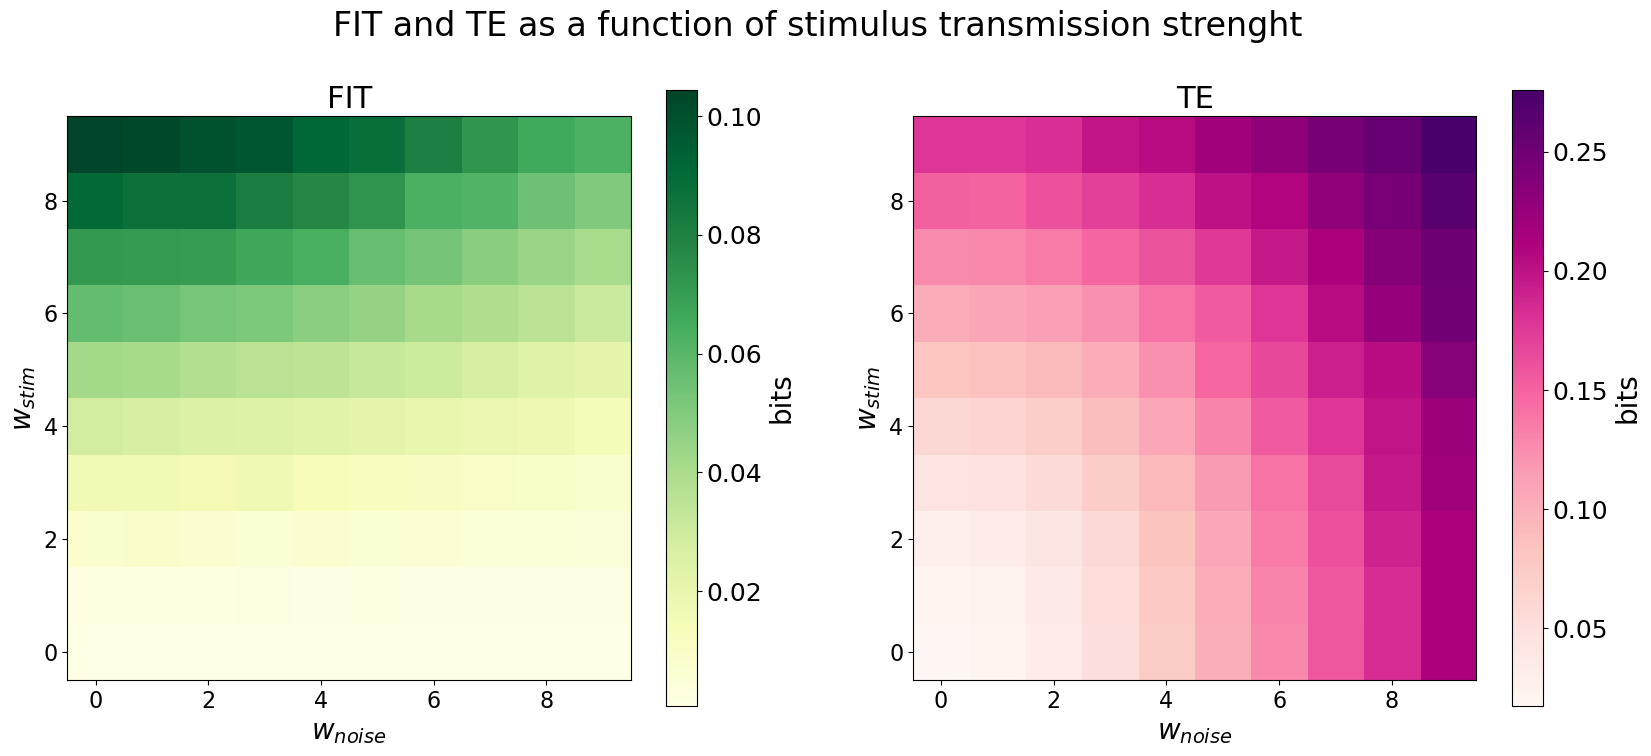

In [78]:
# heatmaps
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8), squeeze = False)

fitvalues = np.mean(fit, axis=0)
tevalues = np.mean(te, axis = 0)

fit_ax = ax[0][0]
te_ax = ax[0][1]

im_fit = fit_ax.imshow(fitvalues, origin='lower', cmap='YlGn')
im_te = te_ax.imshow(tevalues, origin='lower', cmap='RdPu')

fit_ax.set_title('FIT', fontsize=22)
te_ax.set_title('TE', fontsize=22)

cbar_te = te_ax.figure.colorbar(im_te, ax = te_ax)
cbar_fit = te_ax.figure.colorbar(im_fit, ax = fit_ax)

cbar_fit.set_label(label='bits', fontsize=20)
cbar_fit.ax.tick_params(labelsize = 18)

cbar_te.set_label(label='bits', fontsize=20)
cbar_te.ax.tick_params(labelsize = 18)

fit_ax.set_xlabel("$w_{noise}$", fontsize=20)
fit_ax.set_ylabel("$w_{stim}$", fontsize=20)

te_ax.set_xlabel("$w_{noise}$", fontsize=20)
te_ax.set_ylabel("$w_{stim}$", fontsize=20)

fit_ax.tick_params(axis='both', which='major', labelsize=16)
te_ax.tick_params(axis='both', which='major', labelsize=16)

te_ax.set_xlabel("$w_{noise}$")
te_ax.set_ylabel("$w_{stim}$")

plt.suptitle("FIT and TE as a function of stimulus transmission strenght", fontsize = 24)
plt.show()